# Notebook to create LM for People's Names

In [16]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.optim as optim
import time, math, string, random
import matplotlib.pyplot as plt

## Preseting Parameters

In [17]:
# Network Hyperparameters:

create_ngram = False  # Create N-Grams to start
batch_size = 1
n_gram_size = 1
hidden_layers = 128
hidden_size = 1
learning_rate = 0.005
epochs = 1
vocab_size = 1
embedding_dimension = 1
dropout = 0


## Character Level Embeding

In [18]:
all_letters = string.ascii_letters
n_letters = int(len(all_letters)/2 + len(";"))

import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


# Language Model

In [19]:
def check_input_size(input):
    """
    Throws an error if the input is wrong size
    :param input: data for model input
    :return: Nothing
    """
    if input.shape[0] != n_gram_size:
        print("given input shape:", input.shape[0], "expected:", n_gram_size)
        raise RuntimeError("The input is not the correct n-gram")
    elif input.shape[1] != batch_size:
        print("given input shape:", input.shape[1], "expected:", batch_size)
        raise RuntimeError("The input is not the correct batch-size")
    elif input.shape[2] != embedding_dimension:
        print("given input shape:", input.shape[2], "expected:", embedding_dimension)
        raise RuntimeError("The input is not the correct embedding dimension")


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


class run_model():
    def __init__(self, epoch_num, where_is_dat):
        
        self.epoch_num = epoch_num
        self.d = pd.DataFrame(pd.read_csv(where_is_dat))

    
    def create_dataset(self, column_list_x, column_list_y):
        self.dx = self.d[column_list_x[0]]
        self.dy = self.d[column_list_y[0]]
        dx = self.dx.tolist()
        dy = self.dy.tolist()
        temp = lambda x: x  if type(x) == str else ""
        self.max_len = max([len(temp(a)) for a in self.dx.tolist()])
        temp = lambda x: (x + ";;;;;;;;;;;;;;;;;;;;;;;;;;;;;;"[len(x):self.max_len]) if type(x) == str else ""
        self.train_d = [( list(temp(dx[i])), dy[i]) for i in range(len(self.dy))]
        self.train_data = [( lineToTensor(temp(dx[i])), torch.tensor([dy[i]], dtype=torch.long)) \
                           for i in range(len(self.dy))]
        
        range_for_train = random.sample(range(len(self.train_data)), int((4/5)*len(self.train_data)))
        range_for_test =  [x for x in range(len(self.train_data)) if x not in range_for_train]
        self.test_data = [self.train_data[i] for i in range_for_test] 
        self.train_data = [self.train_data[i] for i in range_for_train]
        self.rnn = RNN(n_letters, 128, 2)

    def train(self, category_tensor, line_tensor, crit, optimer):
        
        hidden = self.rnn.initHidden()
        self.rnn.zero_grad()
        
        for i in range(line_tensor.size()[0]):
            output, hidden = self.rnn(line_tensor[i], hidden)
        loss = crit(output, category_tensor)
        loss.backward()
        optimer.step()
        
        # Add parameters' gradients to their values, multiplied by learning rate
        for p in self.rnn.parameters():
            p.data.add_(-learning_rate, p.grad.data)

        return output, loss.item()
    
    
        
    
    def train_my_model(self):
        n_iters = 100000
        print_every = 5000
        plot_every = 500
        current_loss = 0
        self.all_losses = []
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.rnn.parameters(), lr=0.001, momentum=0.9)
        for j in range(self.epoch_num):
            print(j)
            for i in range(len(self.train_data)):
                #print(i)
                if self.train_data[i][0].size()[0] >0:
                    
                    output, loss = self.train(self.train_data[i][1],self.train_data[i][0], criterion, optimizer)
                    current_loss += loss

        
                
                # Add current loss avg to list of losses
                if i % plot_every == 0:
                    self.all_losses.append(current_loss / plot_every)
                    current_loss = 0
            
            print(model_performance(self.test_data, self))
    
def initial_weights():
    h0 = torch.randn(hidden_layers, batch_size, hidden_size)
    c0 = torch.randn(hidden_layers, batch_size, hidden_size)
    return h0, c0

def evaluate(line_tensor, model):
    hidden = model.rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = model.rnn(line_tensor[i], hidden)
    
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return category_i

def model_performance(data_set, model):
    return sum([0 if evaluate(item[0], model) == item[1] else 1 for item in data_set])/len(data_set)

In [20]:
mod = run_model(2, "../Data/Gender/English_names.csv")
mod.create_dataset(["Name"], ["Gender"])

In [21]:
mod.train_my_model()

0
0.37701457185520826
1
0.37701457185520826


In [22]:
evaluate(lineToTensor("Addidas"), mod)

1

In [23]:
sum(mod.d[["Dog"]].values)
len(mod.d[["Dog"]].values) - sum(mod.d[["Dog"]].values)

KeyError: "None of [Index(['Dog'], dtype='object')] are in the [columns]"

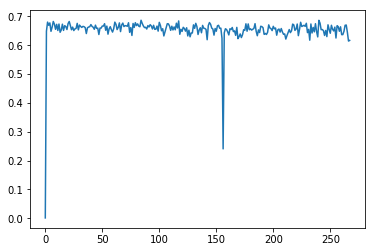

In [24]:
plt.plot(mod.all_losses)

In [25]:
sum([x[1].numpy()[0] == 1 for x in mod.test_data])/len(mod.test_data)

0.6229854281447917

In [26]:
evaluate(lineToTensor("tible"), mod)

1

In [27]:
model_performance(mod.test_data, mod)

0.37701457185520826

In [163]:
mod = run_model(2, "../Data/Brand Gender Data/English_names.csv")
mod.create_dataset(["Name"], ["Gender"])

In [159]:
mod = run_model(2, "../Data/Brand Gender Data/Brand_names.csv")
mod.create_dataset(["Name"], ["Gender"])

In [15]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, 2)

In [16]:
len(mod.train_data)

13384

In [17]:
len(mod.test_data)

3346